Adapted from [Stanford CS224N](https://web.stanford.edu/class/cs224n/) Assignment 1 and [lecture](https://web.stanford.edu/class/cs224n/slides_w25/cs224n-2025-lecture01-wordvecs1.pdf)


In [ ]:
#!pip install datasets

In [3]:
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from datasets import load_dataset
imdb_dataset = load_dataset("stanfordnlp/imdb", name="plain_text")

import re
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NUM_SAMPLES = 150

np.random.seed(0)
random.seed(0)

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, we will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *word2vec*. 

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## How do we represent the meaning of a word (in computers)?

This is the main, motivating question behind word embeddings.

Meaning of a word is a historical, linguistic, and philosophical question. Definitions vary between discplines as well as between approaches in all these domains. We won't be getting into those discussions in this class. Instead, we will focus on how meaning is understood and studied in the field of natural language processing.

### WordNet

Before word embeddings one solution was to use, e.g., WordNet, a thesaurus containing lists of
synonym sets and hypernyms (“is a” relationships)

In [16]:
# synonyms set containing "good"

from nltk.corpus import wordnet as wn
poses = { 'n':'noun', 'v':'verb', 's':'adj (s)', 'a':'adj', 'r':'adv'}
for synset in wn.synsets("good"):
    print("{}: {}".format(poses[synset.pos()],
        ", ".join([l.name() for l in synset.lemmas()])))

noun: good
noun: good, goodness
noun: good, goodness
noun: commodity, trade_good, good
adj: good
adj (s): full, good
adj: good
adj (s): estimable, good, honorable, respectable
adj (s): beneficial, good
adj (s): good
adj (s): good, just, upright
adj (s): adept, expert, good, practiced, proficient, skillful, skilful
adj (s): good
adj (s): dear, good, near
adj (s): dependable, good, safe, secure
adj (s): good, right, ripe
adj (s): good, well
adj (s): effective, good, in_effect, in_force
adj (s): good
adj (s): good, serious
adj (s): good, sound
adj (s): good, salutary
adj (s): good, honest
adj (s): good, undecomposed, unspoiled, unspoilt
adj (s): good
adv: well, good
adv: thoroughly, soundly, good


In [17]:
# hypernyms of "panda"
from nltk.corpus import wordnet as wn
panda = wn.synset("panda.n.01")
hyper = lambda s: s.hypernyms()
list(panda.closure(hyper))

[Synset('procyonid.n.01'),
 Synset('carnivore.n.01'),
 Synset('placental.n.01'),
 Synset('mammal.n.01'),
 Synset('vertebrate.n.01'),
 Synset('chordate.n.01'),
 Synset('animal.n.01'),
 Synset('organism.n.01'),
 Synset('living_thing.n.01'),
 Synset('whole.n.02'),
 Synset('object.n.01'),
 Synset('physical_entity.n.01'),
 Synset('entity.n.01')]

Problems with resources like WordNet

- A useful resource but missing nuance:
  - e.g., “proficient” is listed as a synonym for “good” This is only correct in some contexts
  - Also, WordNet list offensive synonyms in some synonym sets without any coverage of the connotations or appropriateness of words
- Missing new meanings of words:
  - e.g., wicked, badass, nifty, wizard, genius, ninja, bombest
  - Impossible to keep up-to-date!
- Subjective
- Requires human labor to create and adapt

### Representing words as discrete symbols

In traditional NLP, we regard words as discrete symbols. Such symbols for words can be represented by *one-hot vectors*:
- Each word is represented by a vector whose length/dimension equals the size of the vocabulary (e.g., 500,000+).
- In a one-hot vector, all entries are 0 except for a single 1 at the position corresponding to that word.

This is conceptually similar to document term matrix.

Suppose we have a tiny corpus of three documents:

- Doc 1: `"cat sat"`
- Doc 2: `"dog sat"`
- Doc 3: `"cat lay"`

Our vocabulary is: `["cat", "dog", "lay", "sat"]`

Each word can be represented as a one-hot vector:

- `"cat"` → [1, 0, 0, 0]
- `"dog"` → [0, 1, 0, 0]
- `"lay"` → [0, 0, 1, 0]
- `"sat"` → [0, 0, 0, 1]

Now, we can build a **document-term matrix (DTM)** for our corpus:

|        | cat | dog | lay | sat |
|--------|-----|-----|-----|-----|
| Doc 1  |  1  |  0  |  0  |  1  |
| Doc 2  |  0  |  1  |  0  |  1  |
| Doc 3  |  1  |  0  |  1  |  0  |

Each row is a document, and each column is a word from our vocabulary. The values show how many times each word appears in each document.




The main problem with one-hot vectors is that we cannot calculate similarity. 

### Representing words by their context

**Distributional semantics**: A word’s meaning is given by the words that frequently appear close-by

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

- When a word w appears in a text, its context is the set of words that appear nearby (within a fixed-size window).
- We use the many contexts of w to build up a representation of w

![](../img/word_context.png)


![](../img/word_vector.png)

![](../img/word_meaning.png)

## Count-Based Word Vectors

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://web.stanford.edu/~jurafsky/slp3/6.pdf) or [here](https://web.archive.org/web/20190530091127/https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

In NLP, we commonly use `<START>` and `<END>` tokens to mark the beginning and end of sentences, paragraphs, or documents. These tokens are included in co-occurrence counts, encapsulating each document, for example: "`<START>` All that glitters is not gold `<END>`".

The matrix rows (or columns) provide word vectors based on word-word co-occurrence, but they can be large. To reduce dimensionality, we employ Singular Value Decomposition (SVD), akin to PCA, selecting the top $k$ principal components. The SVD process decomposes the co-occurrence matrix $A$ into singular values in the diagonal $S$ matrix and new, shorter word vectors in $U_k$.

![](../img/svd.png)

This dimensionality reduction maintains semantic relationships; for instance, *doctor* and *hospital* will be closer than *doctor* and *dog*.

For those unfamiliar with eigenvalues and SVD, a beginner-friendly introduction to SVD is available [here](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). Additional resources for in-depth understanding include lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168, providing high-level treatment of these algorithms. For practical implementation, utilizing pre-programmed functions from Python packages like numpy, scipy, or sklearn is recommended. While applying full SVD to large corpora can be memory-intensive, scalable techniques such as Truncated SVD exist for extracting the top $k$ vector components efficiently.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. We provide a `read_corpus` function below that pulls out the text of a movie review from the dataset. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [4]:
# Created by Stanford CS224N team

def read_corpus():
    """ Read files from the Large Movie Review Dataset.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = imdb_dataset["train"]["text"][:NUM_SAMPLES]
    return [[START_TOKEN] + [re.sub(r'[^\w]', '', w.lower()) for w in f.split(" ")] + [END_TOKEN] for f in files]

Let's have a look what these documents are like….

In [5]:
imdb_corpus = read_corpus()
pprint.pprint(imdb_corpus[:3], compact=True, width=100)
print("corpus size: ", len(imdb_corpus[0]))

[['<START>', 'i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because',
  'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first',
  'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized',
  'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore',
  'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to',
  'see', 'this', 'for', 'myselfbr', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young',
  'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything',
  'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her',
  'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average',
  'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam',
  'war', 'and', 'race', 'issu

### `distinct_words`

Write a method to work out the distinct words (word types) that occur in the corpus.

You can use `for` loops to process the input `corpus` (a list of list of strings), but try using Python list comprehensions (which are generally faster). In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [ ]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    # Use a set to collect unique words
    unique_words = set()
    for document in corpus:
        for word in document:
            unique_words.add(word)
    
    # Sort the unique words
    corpus_words = sorted(list(unique_words))
    n_corpus_words = len(corpus_words)

    return corpus_words, n_corpus_words

### `compute_co_occurrence_matrix`

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [8]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    
    words, n_words = distinct_words(corpus)
    M = np.zeros((n_words, n_words), dtype=np.int32)
    word2ind = {word: idx for idx, word in enumerate(words)}
    
    for document in corpus:
        doc_length = len(document)
        for idx, word in enumerate(document):
            word_idx = word2ind[word]
            # Define window boundaries
            start = max(0, idx - window_size)
            end = min(doc_length, idx + window_size + 1)
            for i in range(start, end):
                if i != idx:
                    context_word = document[i]
                    context_idx = word2ind[context_word]
                    M[word_idx, context_idx] += 1


    return M, word2ind

### `reduce_to_k_dim`

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [ ]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensional word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10    # Use this parameter in your call to `TruncatedSVD`
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)

    print("Done.")
    return M_reduced

###  `plot_embeddings`

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [12]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    plt.figure(figsize=(8, 6))
    
    for word in words:
        idx = word2ind[word]
        x, y = M_reduced[idx, 0], M_reduced[idx, 1]
        plt.scatter(x, y, marker='o', color='red')
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)
    
    plt.title("2D Word Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

### Co-Occurrence Plot Analysis

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Large Movie Review corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It can take up to a few minutes to run.

Running Truncated SVD over 5880 words...
Done.


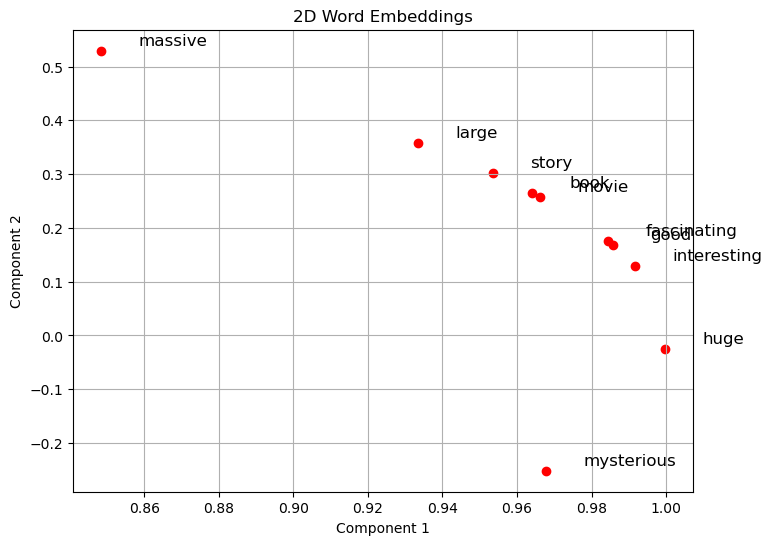

In [14]:
imdb_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(imdb_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)